# ShallowNet on Animals

In [1]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# import the necessary packages
import cv2

class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height,
        # and interpolation method used when resizing
        self.width = width
        self.height = height
        self.inter = inter
        
    def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect ratio
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [3]:
import numpy as np
import cv2
import os

class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors
        
        # if the preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []
            
    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []
        
        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class label 
            # assuming that our path has the following format:
            # /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]
            
            # check to see if our preprocessors are not None
            if self.preprocessors is not None:
                # loop over the preprocessors and apply each to the image
                for p in self.preprocessors:
                    image = p.preprocess(image)
                    
            # treat our processed image as a "feature vector" 
            # by updating the data list followed by the labels
            data.append(image)
            labels.append(label)
            
            # show an update every 'verbose' images
            if verbose > 0 and i >= 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1, len(imagePaths)))
                
        # return a tuple of the data and labels
        return (np.array(data), np.array(labels))

In [4]:
# import the necessary packages
from keras.preprocessing.image import img_to_array

class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
        # store the image data format
        self.dataFormat = dataFormat

    def preprocess(self, image):
        # apply the Keras utility function that correctly rearranges
        # the dimensions of the image
        return img_to_array(image, data_format=self.dataFormat)

Using TensorFlow backend.
/home/pedro/anaconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pedro/anaconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pedro/anaconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [5]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

class ShallowNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last"
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            
        # define the first (and only) CONV => RELU layer
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        
        # softmax classifier
        model.add(Flatten())
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        # return the constructed network architecture
        return model

In [6]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# path to input dataset
dataset = './datasets/animals/'

import glob

# grab the list of images that we'll be describing
print("[INFO] loading images...")
imagePaths = [file for file in glob.glob(dataset + "**/*.jpg", recursive=True)]

[INFO] loading images...


In [8]:
# initialize the image preprocessors
simplePreprocessor = SimplePreprocessor(32, 32)
imageToArrayPreprocessor = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
simpleDatasetLoader = SimpleDatasetLoader(preprocessors=[simplePreprocessor, imageToArrayPreprocessor])
(data, labels) = simpleDatasetLoader.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0

[INFO] processed 500/3000
[INFO] processed 1000/3000
[INFO] processed 1500/3000
[INFO] processed 2000/3000
[INFO] processed 2500/3000
[INFO] processed 3000/3000


In [9]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

In [10]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.005)
model = ShallowNet.build(width=32, height=32, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=100, verbose=1)

[INFO] compiling model...
[INFO] training network...
Train on 2250 samples, validate on 750 samples
Epoch 1/100
2250/2250 [==============================] - 5s 2ms/step - loss: 1.0125 - acc: 0.4800 - val_loss: 0.9958 - val_acc: 0.5200
Epoch 2/100
2250/2250 [==============================] - 0s 76us/step - loss: 0.9269 - acc: 0.5329 - val_loss: 0.8994 - val_acc: 0.5573
Epoch 3/100
2250/2250 [==============================] - 0s 76us/step - loss: 0.8959 - acc: 0.5524 - val_loss: 1.0068 - val_acc: 0.5147
Epoch 4/100
2250/2250 [==============================] - 0s 83us/step - loss: 0.8743 - acc: 0.5636 - val_loss: 0.9036 - val_acc: 0.5413
Epoch 5/100
2250/2250 [==============================] - 0s 80us/step - loss: 0.8560 - acc: 0.5631 - val_loss: 0.8912 - val_acc: 0.5480
Epoch 6/100
2250/2250 [==============================] - 0s 79us/step - loss: 0.8390 - acc: 0.5827 - val_loss: 0.9712 - val_acc: 0.4920
Epoch 7/100
2250/2250 [==============================] - 0s 77us/step - loss: 0.8254 

In [11]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), 
                            predictions.argmax(axis=1), 
                            target_names=["cat", "dog", "panda"]))

[INFO] evaluating network...
              precision    recall  f1-score   support

         cat       0.67      0.39      0.50       249
         dog       0.55      0.76      0.64       262
       panda       0.84      0.85      0.84       239

    accuracy                           0.67       750
   macro avg       0.69      0.67      0.66       750
weighted avg       0.68      0.67      0.66       750



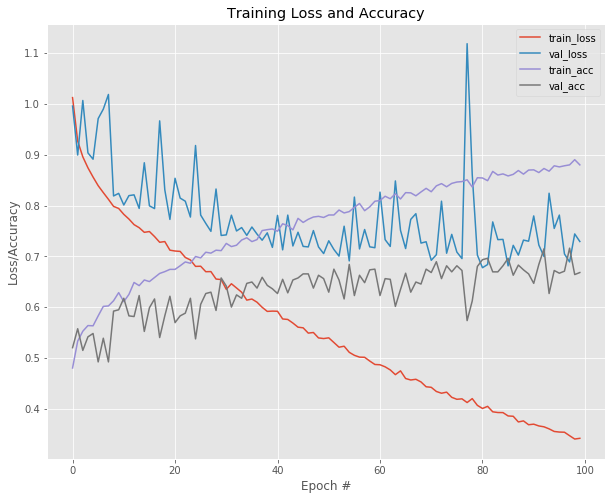

In [12]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# ShallowNet on CIFAR-10

In [13]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# load the training and testing data, scale it into the range [0, 1],
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

# convert the labels from integers to vectors
labelBinarizer = LabelBinarizer()
trainY = labelBinarizer.fit_transform(trainY)
testY = labelBinarizer.transform(testY)

# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

[INFO] loading CIFAR-10 data...


In [15]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01)
model = ShallowNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=40, verbose=1)

[INFO] compiling model...
[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 4s 81us/step - loss: 1.8167 - acc: 0.3630 - val_loss: 1.6532 - val_acc: 0.4172
Epoch 2/40
50000/50000 [==============================] - 4s 78us/step - loss: 1.5579 - acc: 0.4634 - val_loss: 1.4689 - val_acc: 0.4806
Epoch 3/40
50000/50000 [==============================] - 4s 78us/step - loss: 1.3966 - acc: 0.5129 - val_loss: 1.4022 - val_acc: 0.4967
Epoch 4/40
50000/50000 [==============================] - 4s 82us/step - loss: 1.3142 - acc: 0.5402 - val_loss: 1.3438 - val_acc: 0.5162
Epoch 5/40
50000/50000 [==============================] - 4s 79us/step - loss: 1.2608 - acc: 0.5598 - val_loss: 1.3421 - val_acc: 0.5238
Epoch 6/40
50000/50000 [==============================] - 4s 78us/step - loss: 1.2241 - acc: 0.5715 - val_loss: 1.2601 - val_acc: 0.5541
Epoch 7/40
50000/50000 [==============================] - 4s 79us/step - lo

In [16]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.60      0.71      0.65      1000
  automobile       0.67      0.81      0.73      1000
        bird       0.50      0.39      0.44      1000
         cat       0.42      0.50      0.46      1000
        deer       0.45      0.67      0.54      1000
         dog       0.54      0.44      0.49      1000
        frog       0.72      0.72      0.72      1000
       horse       0.80      0.53      0.64      1000
        ship       0.76      0.70      0.73      1000
       truck       0.80      0.57      0.67      1000

    accuracy                           0.61     10000
   macro avg       0.63      0.61      0.61     10000
weighted avg       0.63      0.61      0.61     10000



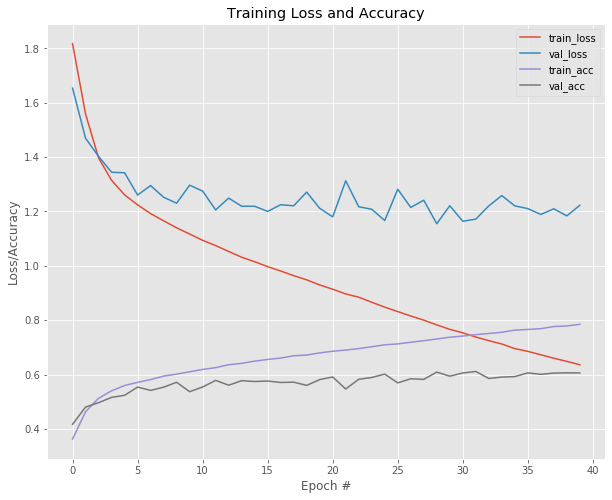

In [17]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()